Scooped from here: [https://mygeoblog.com/2017/10/06/from-gee-to-numpy-to-geotiff/]

In [1]:
import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
import time

In [2]:
# init the ee object
ee.Initialize()

In [3]:
# Define the area
area = ee.Geometry.Polygon([[[105.532,19.059],[105.606,19.058],[105.605,19.108],[105.530,19.110],[105.532,19.059]]])

In [4]:
# define the image
img = ee.Image("COPERNICUS/S2/20160209T034234_20160209T090731_T48QWG")

In [5]:
# do any ee operation here
ndvi = ee.Image(img.normalizedDifference(['B8', 'B4']))
timedate = img.get('GENERATION_TIME').getInfo()

In [6]:
# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(ndvi)

In [7]:
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels=1e8,
  scale=20);

In [8]:
# get data into three different arrays
data = np.array((ee.Array(latlon.get("nd")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

In [9]:
# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)

In [10]:
# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)

In [11]:
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]

In [12]:
# create an array with dimensions of image
arr = np.zeros([nrows, ncols], np.float32) #-9999

In [13]:
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner

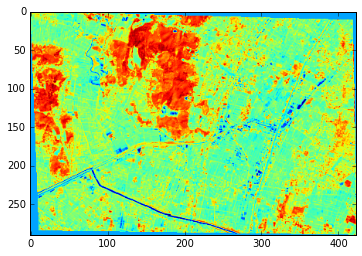

In [14]:
# in case you want to plot the image
import matplotlib.pyplot as plt        
plt.imshow(arr)
plt.show()

In [15]:
# set the 
#SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)

In [16]:
# set the coordinate system
target = osr.SpatialReference()
target.ImportFromEPSG(4326)

6

In [17]:
# set driver
driver = gdal.GetDriverByName('GTiff')

In [18]:
timestring = time.strftime("%Y%m%d_%H%M%S")
outputDataset = driver.Create("/path/to/output.tif", ncols,nrows, 1,gdal.GDT_Float32)

In [19]:
# add some metadata
outputDataset.SetMetadata( {'time': str(timedate), 'someotherInfo': 'lala'} )
 
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(arr)
outputDataset.GetRasterBand(1).SetNoDataValue(-9999)
outputDataset = None

AttributeError: 'NoneType' object has no attribute 'SetMetadata'